<a href="https://colab.research.google.com/github/giabao804/ML_VIN/blob/main/Copy_of_01_GAN_MNIST_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Thực hành về mạng GAN

### Chuẩn bị các thư viện cần thiết

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import glob
import cv2
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm
import matplotlib.pyplot as plt
from torchsummary import summary

### Thiết lập các hằng số cho tập MNIST

In [2]:
width    = 28
height   = 28
channels = 1
epochs   = 1000

img_shape = (width, height, channels)

<H2>1. Tải tập dữ liệu MNIST</H2>

Ta chỉ dùng tập huấn luyện, không dùng nhãn. Các điểm ảnh được chuẩn hoá về miền giá trị [-1, 1]

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

batch_size = 32

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 14874871.20it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 443244.77it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3923825.41it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3228356.00it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Trực quan dữ liệu MNIST

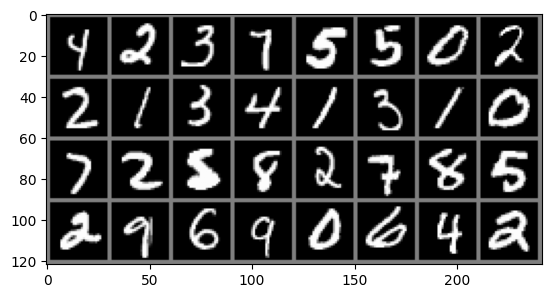

    4     2     3     7     5     5     0     2     2     1     3     4     1     3     1     0     7     2     5     8     2     7     8     5     2     9     6     9     0     6     4     2


In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j].item() for j in range(batch_size)))

<H2>2. Generator</H2>
Lập trình kiến trúc Generator theo mô tả phía dưới

In [6]:
""" Declare GENERATOR.
    + Its input is a 100-feature vector of random noise
    + Its output is a fake image with pixel values in [-1, 1]"""

class Generator(nn.Module):

    ##########################
    ###   YOUR CODE HERE   ###
    ##########################
    def __init__(self):
      super(Generator, self).__init__()
      self.model = nn.Sequential(
          nn.Linear(100, 256),
          nn.LeakyReLU(0.25),
          nn.BatchNorm1d(256, momentum=0.8),

          nn.Linear(256, 512),
          nn.LeakyReLU(0.2),
          nn.BatchNorm1d(512, momentum=0.8),

          nn.Linear(512, 1024),
          nn.LeakyReLU(0.2),
          nn.BatchNorm1d(1024, momentum=0.8),

          nn.Linear(1024, width  * height * channels),
          nn.Tanh(),
        )
    def forward(self, x):
        x = self.model(x)
        return x.view(-1, width, height, channels)

G = Generator().cuda()
summary(G, (100, ), batch_size=-1, device='cuda')
print("_____________________ Generator Created_____________________")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]          25,856
         LeakyReLU-2                  [-1, 256]               0
       BatchNorm1d-3                  [-1, 256]             512
            Linear-4                  [-1, 512]         131,584
         LeakyReLU-5                  [-1, 512]               0
       BatchNorm1d-6                  [-1, 512]           1,024
            Linear-7                 [-1, 1024]         525,312
         LeakyReLU-8                 [-1, 1024]               0
       BatchNorm1d-9                 [-1, 1024]           2,048
           Linear-10                  [-1, 784]         803,600
             Tanh-11                  [-1, 784]               0
Total params: 1,489,936
Trainable params: 1,489,936
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

<H2>3. Discriminator</H2>
Lập trình kiến trúc Discriminator

In [8]:
""" Declare DISCRIMINATOR
    Its input is REAL IMAGE (in a form of a vector 28x28)
    Its ouput is the probability of image type (REAL IMAGE or FAKE IMAGE)
    the values in the range of [0, 1] """

class Discriminator(nn.Module):
    ##########################
    ###   YOUR CODE HERE   ###
    ##########################
    def __init__(self):
      super(Discriminator, self).__init__()
      self.model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28 * 1 , 784),
        nn.LeakyReLU(0.2),
        nn.Linear( 784, 392),
        nn.LeakyReLU(0.2),
        nn.Linear(392, 1),
        nn.Sigmoid(),
    )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.model(x)

        return x

D = Discriminator().cuda()
summary(D, img_shape, batch_size=-1, device='cuda')
print("____________________ Discriminator Created____________________")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 784]         615,440
         LeakyReLU-3                  [-1, 784]               0
            Linear-4                  [-1, 392]         307,720
         LeakyReLU-5                  [-1, 392]               0
            Linear-6                    [-1, 1]             393
           Sigmoid-7                    [-1, 1]               0
Total params: 923,553
Trainable params: 923,553
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 3.52
Estimated Total Size (MB): 3.55
----------------------------------------------------------------
____________________ Discriminator Created____________________


<h2>4. Generative model</h2>

Xây dựng GAN và huấn luyện

In [16]:
optimizer_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=8e-8)
optimizer_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=8e-8)

epochs        = 10
adversarial_loss = nn.BCELoss().cuda()

losses_G = []
losses_D = []
samples = []

In [17]:
for epoch in range(epochs):
    for (i, (imgs, _)) in enumerate(trainloader, start=1):
        # Adversarial ground truths
        valid = Variable(torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(torch.cuda.FloatTensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(torch.cuda.FloatTensor(np.random.normal(0, 1, (imgs.shape[0], 100))))

        # Generate a batch of images
        gen_imgs = G(z)

        # Loss measures generator's ability to fool the discriminator

        ##########################
        ###   YOUR CODE HERE   ###
        g_loss = adversarial_loss(D(gen_imgs), valid)
        ##########################

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss measures discriminator's ability to classify real from generated samples

        ##########################
        ###   YOUR CODE HERE   ###
        real_loss = adversarial_loss(D(real_imgs), valid)
        fake_loss = adversarial_loss(D(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        ##########################


        d_loss.backward()
        optimizer_D.step()

        if epoch % 1 == 0 and i == len(trainloader):
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, epochs, i, len(trainloader), d_loss.item(), g_loss.item())
            )

            losses_G.append(g_loss.item())
            losses_D.append(d_loss.item())
            samples.append(gen_imgs)


[Epoch 0/10] [Batch 1875/1875] [D loss: 0.544985] [G loss: 1.042410]
[Epoch 1/10] [Batch 1875/1875] [D loss: 0.616697] [G loss: 0.802132]
[Epoch 2/10] [Batch 1875/1875] [D loss: 0.588472] [G loss: 0.743052]
[Epoch 3/10] [Batch 1875/1875] [D loss: 0.629203] [G loss: 1.136317]
[Epoch 4/10] [Batch 1875/1875] [D loss: 0.582591] [G loss: 0.992433]
[Epoch 5/10] [Batch 1875/1875] [D loss: 0.535729] [G loss: 0.916985]
[Epoch 6/10] [Batch 1875/1875] [D loss: 0.658320] [G loss: 1.027049]
[Epoch 7/10] [Batch 1875/1875] [D loss: 0.569615] [G loss: 0.780609]
[Epoch 8/10] [Batch 1875/1875] [D loss: 0.581453] [G loss: 1.316595]
[Epoch 9/10] [Batch 1875/1875] [D loss: 0.516400] [G loss: 1.229843]


### Vẽ đồ thị hàm loss huấn luyện

In [18]:
losses_G

[1.0424100160598755,
 0.8021317720413208,
 0.7430522441864014,
 1.1363173723220825,
 0.9924334287643433,
 0.9169845581054688,
 1.0270487070083618,
 0.7806093692779541,
 1.3165946006774902,
 1.2298429012298584]

In [19]:
losses_D

[0.5449845790863037,
 0.6166969537734985,
 0.5884716510772705,
 0.6292027831077576,
 0.5825910568237305,
 0.5357292890548706,
 0.6583203077316284,
 0.5696150660514832,
 0.5814533233642578,
 0.5164002180099487]

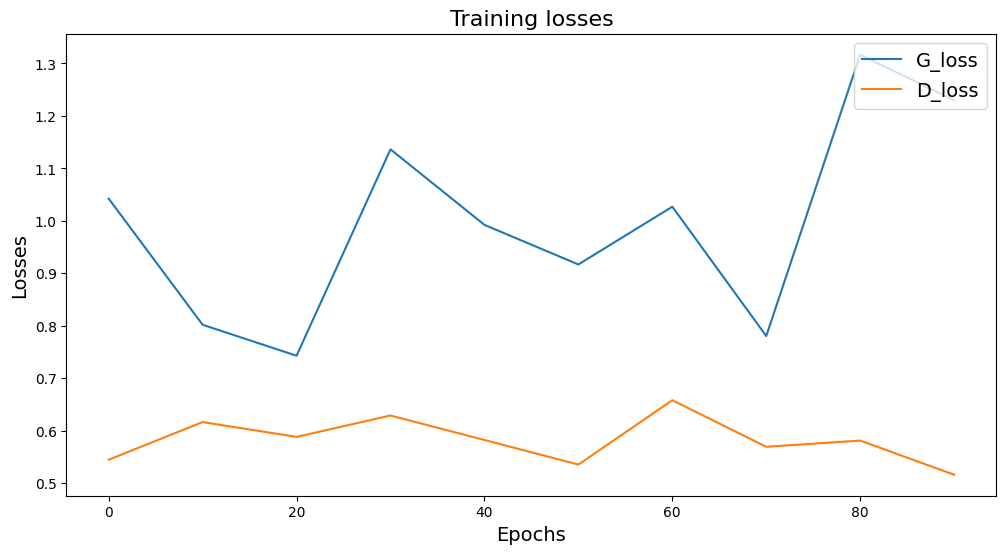

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(list(range(0, len(losses_G)*10, 10)), losses_G, label="G_loss")
plt.plot(list(range(0, len(losses_D)*10, 10)), losses_D, label="D_loss")
plt.title("Training losses", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Losses", fontsize=14)
plt.legend(loc="upper right", fontsize=14)
plt.show()

### Trực quan hoá kết quả sinh dữ liệu của mô hình đã huấn luyện

    ____________________ Step = 0 ____________________    ____________________ Step = 0 ____________________    ____________________ Step = 0 ____________________    ____________________ Step = 0 ____________________    ____________________ Step = 0 ____________________    ____________________ Step = 0 ____________________    ____________________ Step = 0 ____________________    ____________________ Step = 0 ____________________    ____________________ Step = 0 ____________________    ____________________ Step = 0 ____________________


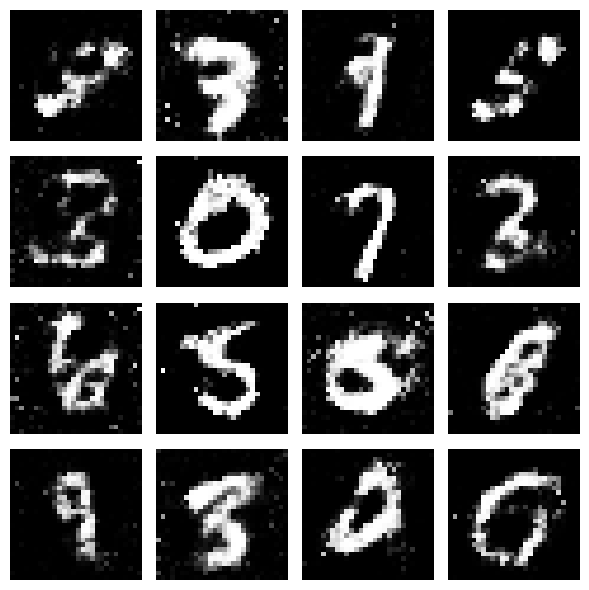



    ____________________ Step = 1 ____________________    ____________________ Step = 1 ____________________    ____________________ Step = 1 ____________________    ____________________ Step = 1 ____________________    ____________________ Step = 1 ____________________    ____________________ Step = 1 ____________________    ____________________ Step = 1 ____________________    ____________________ Step = 1 ____________________    ____________________ Step = 1 ____________________    ____________________ Step = 1 ____________________


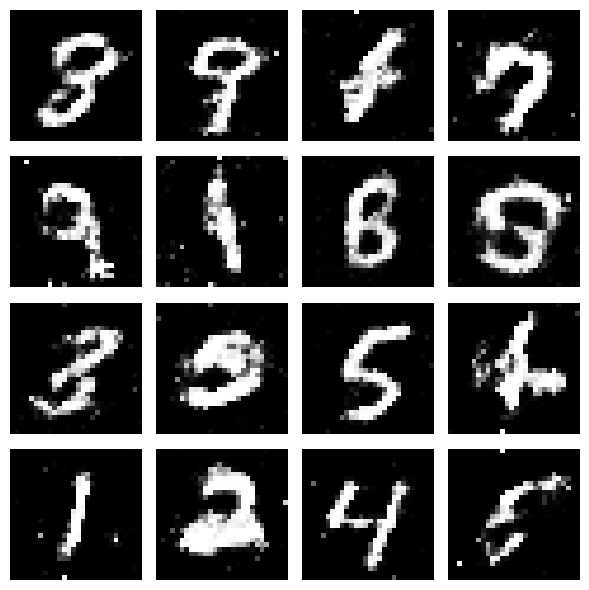



    ____________________ Step = 2 ____________________    ____________________ Step = 2 ____________________    ____________________ Step = 2 ____________________    ____________________ Step = 2 ____________________    ____________________ Step = 2 ____________________    ____________________ Step = 2 ____________________    ____________________ Step = 2 ____________________    ____________________ Step = 2 ____________________    ____________________ Step = 2 ____________________    ____________________ Step = 2 ____________________


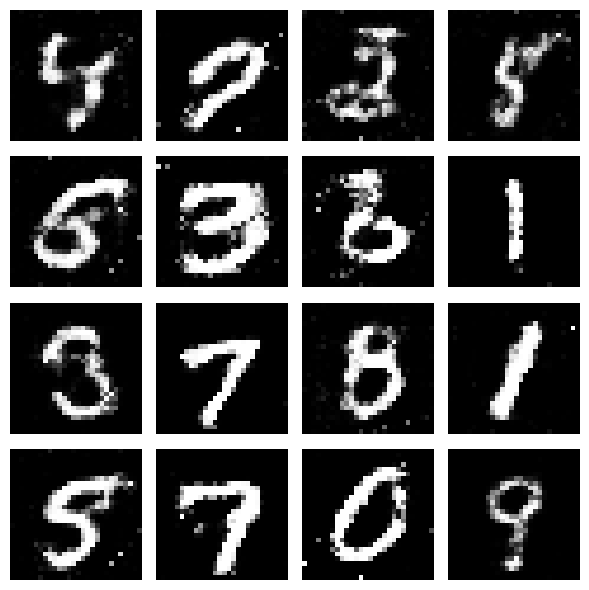



    ____________________ Step = 3 ____________________    ____________________ Step = 3 ____________________    ____________________ Step = 3 ____________________    ____________________ Step = 3 ____________________    ____________________ Step = 3 ____________________    ____________________ Step = 3 ____________________    ____________________ Step = 3 ____________________    ____________________ Step = 3 ____________________    ____________________ Step = 3 ____________________    ____________________ Step = 3 ____________________


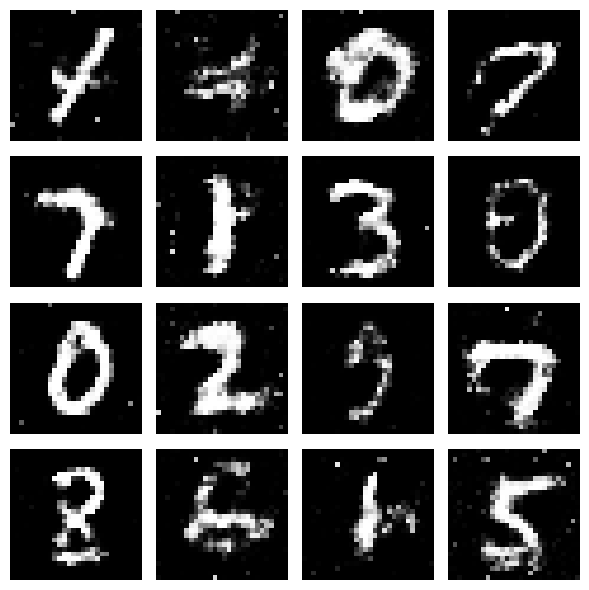



    ____________________ Step = 4 ____________________    ____________________ Step = 4 ____________________    ____________________ Step = 4 ____________________    ____________________ Step = 4 ____________________    ____________________ Step = 4 ____________________    ____________________ Step = 4 ____________________    ____________________ Step = 4 ____________________    ____________________ Step = 4 ____________________    ____________________ Step = 4 ____________________    ____________________ Step = 4 ____________________


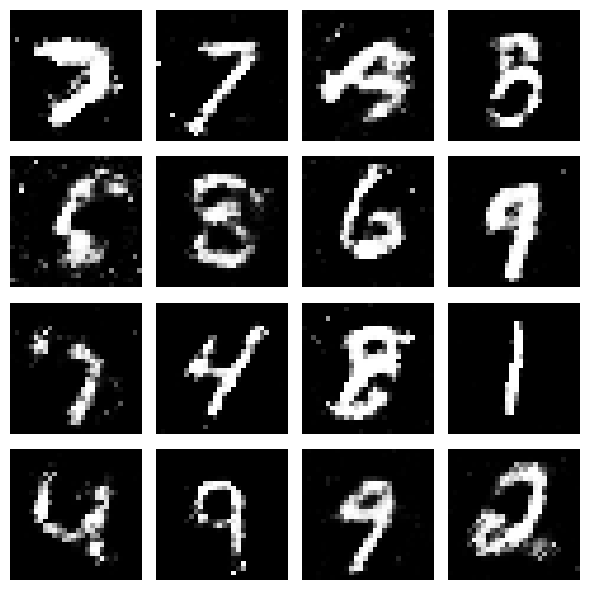



    ____________________ Step = 5 ____________________    ____________________ Step = 5 ____________________    ____________________ Step = 5 ____________________    ____________________ Step = 5 ____________________    ____________________ Step = 5 ____________________    ____________________ Step = 5 ____________________    ____________________ Step = 5 ____________________    ____________________ Step = 5 ____________________    ____________________ Step = 5 ____________________    ____________________ Step = 5 ____________________


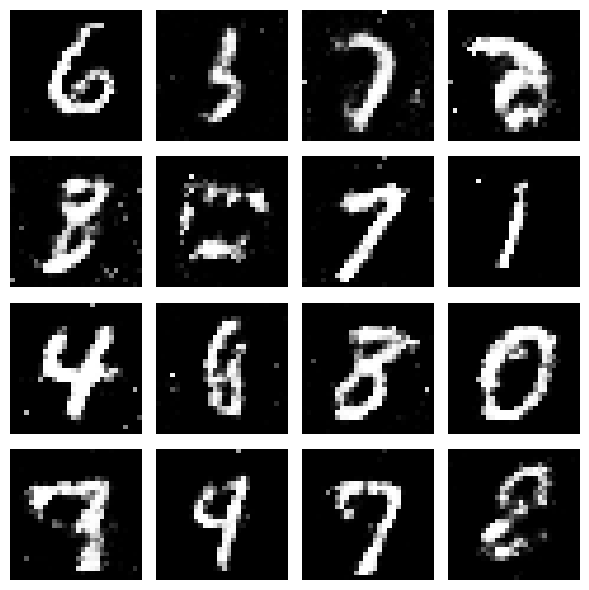



    ____________________ Step = 6 ____________________    ____________________ Step = 6 ____________________    ____________________ Step = 6 ____________________    ____________________ Step = 6 ____________________    ____________________ Step = 6 ____________________    ____________________ Step = 6 ____________________    ____________________ Step = 6 ____________________    ____________________ Step = 6 ____________________    ____________________ Step = 6 ____________________    ____________________ Step = 6 ____________________


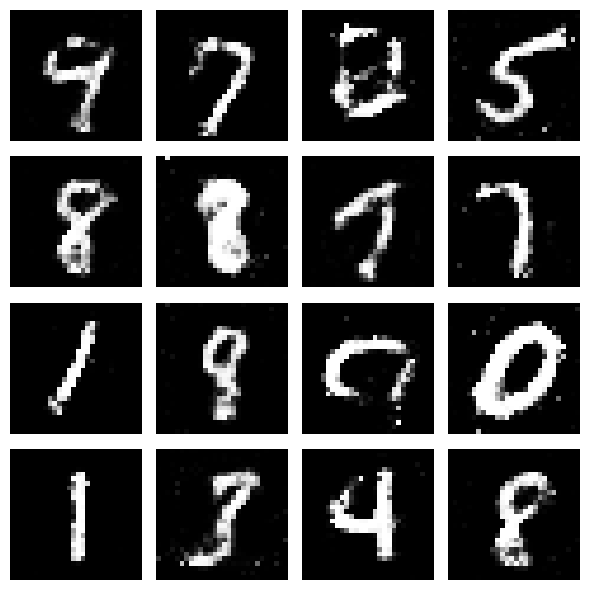



    ____________________ Step = 7 ____________________    ____________________ Step = 7 ____________________    ____________________ Step = 7 ____________________    ____________________ Step = 7 ____________________    ____________________ Step = 7 ____________________    ____________________ Step = 7 ____________________    ____________________ Step = 7 ____________________    ____________________ Step = 7 ____________________    ____________________ Step = 7 ____________________    ____________________ Step = 7 ____________________


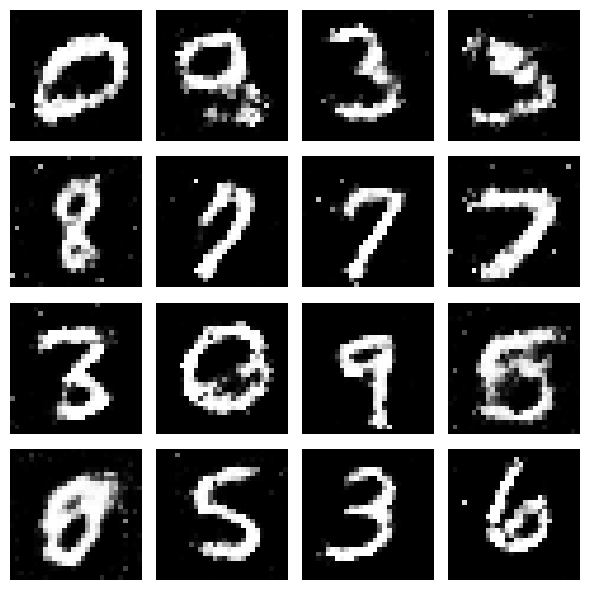



    ____________________ Step = 8 ____________________    ____________________ Step = 8 ____________________    ____________________ Step = 8 ____________________    ____________________ Step = 8 ____________________    ____________________ Step = 8 ____________________    ____________________ Step = 8 ____________________    ____________________ Step = 8 ____________________    ____________________ Step = 8 ____________________    ____________________ Step = 8 ____________________    ____________________ Step = 8 ____________________


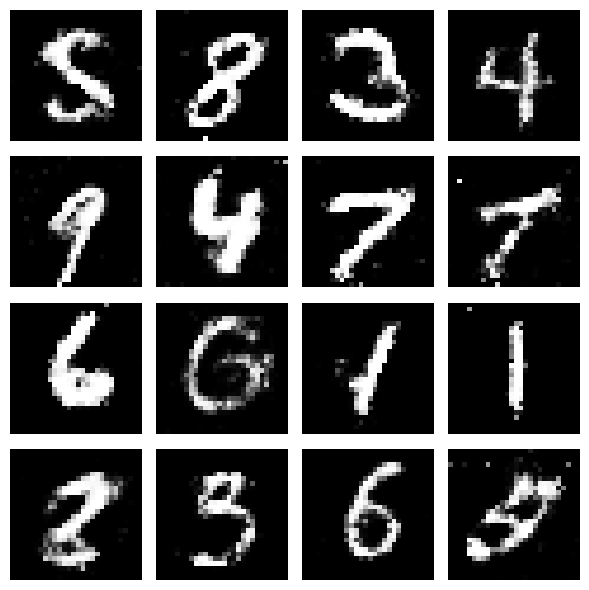



    ____________________ Step = 9 ____________________    ____________________ Step = 9 ____________________    ____________________ Step = 9 ____________________    ____________________ Step = 9 ____________________    ____________________ Step = 9 ____________________    ____________________ Step = 9 ____________________    ____________________ Step = 9 ____________________    ____________________ Step = 9 ____________________    ____________________ Step = 9 ____________________    ____________________ Step = 9 ____________________


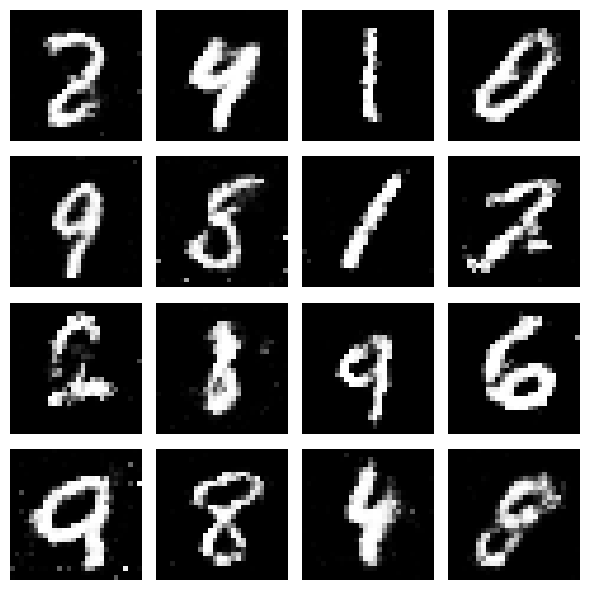

In [21]:
i = 0
for i in range(0, len(samples)):
    images = samples[i].data.cpu().numpy()
    print("    ____________________ Step = %d ____________________" % i*10)
    plt.figure(figsize=(6, 6))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        image = images[i, :, :, :]
        image = np.reshape(image, [height, width])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    print("\n")

### Generate Random

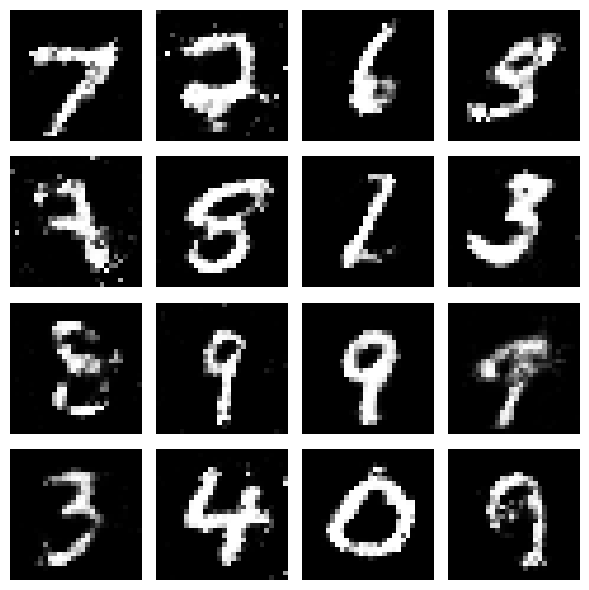

In [22]:
noise = torch.Tensor(np.random.normal(0, 1, (16, 100))).cuda()
gen_images = G(noise)
images = gen_images.data.cpu().numpy()
plt.figure(figsize=(6, 6))
for i in range(16):
    plt.subplot(4, 4, i+1)
    image = images[i, :, :, :]
    image = np.reshape(image, [height, width])
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()